In [3]:
import torch
import esm
import numpy as np
import matplotlib.pyplot as plt



In [4]:
import os, re, textwrap

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
# Load the smallest ESM2

model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

model = model.to(device)
model.eval()
print(model)

ESM2(
  (embed_tokens): Embedding(33, 320, padding_idx=1)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (q_proj): Linear(in_features=320, out_features=320, bias=True)
        (out_proj): Linear(in_features=320, out_features=320, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=320, out_features=1280, bias=True)
      (fc2): Linear(in_features=1280, out_features=320, bias=True)
      (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=120, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((320,), eps=1e-05, elementwis

In [7]:
data = [("test_protein", "MKTLLILAVVAAALA")]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

batch_tokens = batch_tokens.to(device)

with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=False)

token_reps = results["representations"][6]
token_reps.shape

torch.Size([1, 17, 320])

In [8]:
# Convert token embeddings into one embedding per protein
# mean-pool amino acid positions

def mean_pool_protein_embedding(token_reps, batch_tokens, alphabet):
    """
    token_reps: [B, T, D]
    batch_tokens: [B, T]
    Returns: [B, D] pooled embeddings
    """
    padding_idx = alphabet.padding_idx

    # Mask: True for real (non-padding) tokens
    nonpad_mask = batch_tokens.ne(padding_idx)

    lengths = nonpad_mask.sum(dim=1)

    pooled = []
    for i in range(token_reps.size(0)):
        L = lengths[i].item()
        # positions 1..L-2 are actual amino acids (exclude BOS=0 and EOS=L-1)
        reps_i = token_reps[i, 1:L-1, :]
        pooled.append(reps_i.mean(dim=0))
    return torch.stack(pooled, dim=0)

seq_emb = mean_pool_protein_embedding(token_reps, batch_tokens, alphabet)
seq_emb.shape


torch.Size([1, 320])

In [9]:
import requests
import pandas as pd

def fetch_uniprot_fasta(accession: str) -> tuple[str, str]:
    # Returns (header, sequence) from UniProt FASTA.
    url = f"https://rest.uniprot.org/uniprotkb/{accession}.fasta"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    fasta = r.text.strip().splitlines()
    header = fasta[0][1:]  # drop ">"
    seq = "".join(fasta[1:])
    seq = re.sub(r"[^ACDEFGHIKLMNPQRSTVWY]", "", seq)  # keep standard AAs only
    return header, seq

toxin_accessions = [
    "P0A3R9",  # example: E. coli toxin-related protein (may vary)
    "P0A0H3",
    "P0A0H2",
    "P0A0H1",
    "P0A0H0",
]

records = []
for acc in toxin_accessions:
    try:
        header, seq = fetch_uniprot_fasta(acc)
        records.append({"accession": acc, "header": header, "sequence": seq, "length": len(seq)})
    except Exception as e:
        records.append({"accession": acc, "header": None, "sequence": None, "length": None, "error": str(e)})

df = pd.DataFrame(records)
df


,accession,header,sequence,length
0,P0A3R9,sp|P0A3R9|NCZS_STRCZ Neocarzinostatin OS=Strep...,MVPISIIRNRVAKVAVGSAAVLGLAVGFQTPAVAAAPTATVTPSSG...,147
1,P0A0H3,sp|P0A0H3|ERMA_STAAU rRNA adenine N-6-methyltr...,MNQKNPKDTQNFITSKKHVKEILNHTNISKQDNVIEIGSGKGHFTK...,243
2,P0A0H2,sp|P0A0H2|ERMA_STAAN rRNA adenine N-6-methyltr...,MNQKNPKDTQNFITSKKHVKEILNHTNISKQDNVIEIGSGKGHFTK...,243
3,P0A0H1,sp|P0A0H1|ERMA_STAAM rRNA adenine N-6-methyltr...,MNQKNPKDTQNFITSKKHVKEILNHTNISKQDNVIEIGSGKGHFTK...,243
4,P0A0H0,sp|P0A0H0|RS12_STAA8 Small ribosomal subunit p...,MPTINQLVRKPRQSKIKKSDSPALNKGFNSKKKKFTDLNSPQKRGV...,137


In [10]:
import numpy as np
import torch

print(np.__version__)
print(torch.__version__)


2.2.6
2.2.2


In [11]:
def embed_sequences_with_esm(model, alphabet, seq_records, repr_layer: int = 6):
    """
    seq_records: list of dicts with keys {name, sequence}
    Returns: np.ndarray [N, D]
    """
    batch_converter = alphabet.get_batch_converter()
    data = [(r["name"], r["sequence"]) for r in seq_records]

    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)

    with torch.no_grad():
        out = model(batch_tokens, repr_layers=[repr_layer], return_contacts=False)

    token_reps = out["representations"][repr_layer]
    seq_reps = mean_pool_protein_embedding(token_reps, batch_tokens, alphabet)
    return np.array(seq_reps.detach().cpu().tolist(), dtype=np.float32)

# Keep only valid sequences
valid = df[df["sequence"].notna()].copy()
seq_records = [{"name": row["accession"], "sequence": row["sequence"]} for _, row in valid.iterrows()]

X = embed_sequences_with_esm(model, alphabet, seq_records, repr_layer=6)
X.shape


(5, 320)

In [12]:
import umap

reducer = umap.UMAP(
    n_neighbors=3,   # small dataset → keep small
    min_dist=0.2,
    metric="cosine",
    random_state=42
)

Z = reducer.fit_transform(X)
Z.shape

/opt/anaconda3/envs/esm-learn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/esm-learn/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(5, 2)

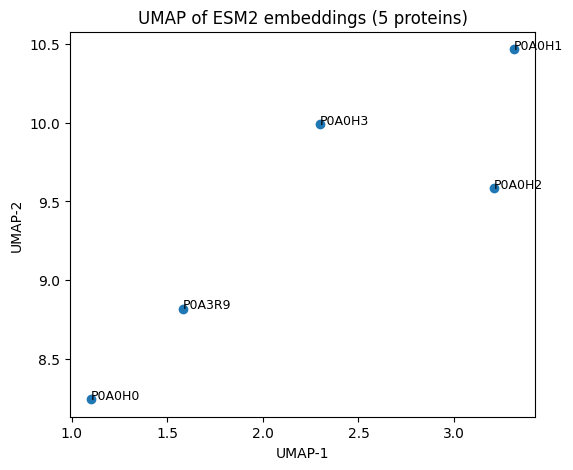

In [13]:
plt.figure(figsize=(6, 5))
plt.scatter(Z[:, 0], Z[:, 1])

for i, name in enumerate(valid["accession"].tolist()):
    plt.text(Z[i, 0], Z[i, 1], name, fontsize=9)

plt.title("UMAP of ESM2 embeddings (5 proteins)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()
